In [102]:
import numpy as np
from sympy import *
from sympy.physics.quantum import TensorProduct as tp

from qiskit import *
from qiskit.quantum_info import *

from qiskit.circuit.library import *

from numpy.testing import assert_almost_equal as aae

import matplotlib.pyplot as plt
import matplotlib

import scipy

from functools import reduce
from scipy.spatial import ConvexHull

In [2]:
mat_close = lambda A, B: np.all(np.isclose(A, B))

The $\gamma$ map is defined as $\gamma: u \mapsto u\sigma_y^{\otimes 2} u^T \sigma_y^{\otimes 2}$. Given a matrix $u \in SU(4)$, I found some pattern in the relationship between the trace of $\gamma(u)$ and the number of CNOT it uses. More specifically, let $\alpha = Tr(\gamma(u))$.

- $|\alpha| = 4 \implies$ 0 CNOT

- $|\alpha| = 0 \implies$ 1 CNOT

- $\alpha \text{ is real} \implies$ 2 CNOT

- $\alpha \text{ is complex} \implies$ 3 CNOT

Whether this implication is always true is in question. It's kinda late so I will probably prove this tomorrow.

In [3]:
sigma_y = np.array([[0, -1j], [1j, 0]])

def to_su(u): # Convert a matrix in U(4) to SU(4)
    u = u / np.sqrt(np.sqrt(np.linalg.det(u)))
    
    return u

def gamma_map(u): # Perform the gamma map above
    
    return u@np.kron(sigma_y, sigma_y)@u.T@np.kron(sigma_y, sigma_y)

def classification(u, output_trace = False):
    
    u = to_su(u)
    
    mat_trace = np.round(np.trace(gamma_map(u)), 14)
    
    if output_trace:
        print(mat_trace)
    
    if (mat_trace == -4) or (mat_trace == 4):
        return 0
    elif mat_trace == 0:
        return 1
    elif np.isreal(mat_trace):
        return 2
    else:
        return 3

I check the classification for CNOT as two qubit gate.

In [4]:
cnot = np.array([[1, 0, 0, 0], 
                 [0, 1, 0, 0], 
                 [0, 0, 0, 1], 
                 [0, 0, 1, 0]])

for i in range(1000):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)
    MC = np.kron(random_unitary(2).data, random_unitary(2).data)
    MD = np.kron(random_unitary(2).data, random_unitary(2).data)

    M0 = MA
    M1 = M0@cnot@MB
    M2 = M1@cnot@MC
    M3 = M2@cnot@MD

    assert classification(M0) == 0, 'zero'
    assert classification(M1) == 1, 'one'
    assert classification(M2) == 2, 'two'
    assert classification(M3) == 3, 'three'

I did a little bit more digging and I found that it also works for $iSWAP$ gate.

In [5]:
isw = iSwapGate().to_matrix()

for i in range(1000):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)
    MC = np.kron(random_unitary(2).data, random_unitary(2).data)
    MD = np.kron(random_unitary(2).data, random_unitary(2).data)

    M0 = MA
    M1 = M0@isw@MB
    M2 = M1@isw@MC
    M3 = M2@isw@MD

    assert classification(M0) == 0, 'zero'
    assert classification(M1) == 1, 'one'
    assert classification(M2) == 2, 'two'
    assert classification(M3) == 3, 'three'

I look at the $\sqrt{iSWAP}$ as the native two qubit gates. Here, the classification changes a little. For 1 gate, the trace is 2. For 2 and 3, the trace is complex. This might have to do with the fact that two $\sqrt{iSWAP}$ gate makes up a 79% of the SU(4) gate.

In [6]:
sqisw = np.array([[1, 0, 0, 0],
                  [0, 1/np.sqrt(2), 1j/np.sqrt(2), 0], 
                  [0, 1j/np.sqrt(2), 1/np.sqrt(2), 0], 
                  [0, 0, 0, 1]])

MA = np.kron(random_unitary(2).data, random_unitary(2).data)
MB = np.kron(random_unitary(2).data, random_unitary(2).data)
MC = np.kron(random_unitary(2).data, random_unitary(2).data)
MD = np.kron(random_unitary(2).data, random_unitary(2).data)

M0 = MA
M1 = M0@sqisw@MB
M2 = M1@sqisw@MC
M3 = M2@sqisw@MD

classification(M0, True)
classification(M1, True)
classification(M2, True)
classification(M3, True)

(4-0j)
(-2-0j)
(-0.70295802053594+0.35241616091568j)
(-0.24545506015024+2.5438222582566j)


3

I look at the values of that the trace covers for two and three $\sqrt{iSWAP}$ gates. The ration btw the two area looks alot like 79%.

In [176]:
#trace_list1 = [] # Two sqiSW

sqisw = np.array([[1, 0, 0, 0],
                  [0, 1/np.sqrt(2), 1j/np.sqrt(2), 0], 
                  [0, 1j/np.sqrt(2), 1/np.sqrt(2), 0], 
                  [0, 0, 0, 1]])

for _ in range(1):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)
    MC = np.kron(random_unitary(2).data, random_unitary(2).data)

    M = MA@sqisw@MB@sqisw@MC

    M = to_su(M)

    mat_trace = np.trace(gamma_map(M))
    
    trace_list1.append(mat_trace)
    
#trace_list2 = [] # Three sqiSW

for _ in range(20_000):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)
    MC = np.kron(random_unitary(2).data, random_unitary(2).data)
    MD = np.kron(random_unitary(2).data, random_unitary(2).data)
    
    M = MA@sqisw@MB@sqisw@MC@sqisw@MD

    M = to_su(M)

    mat_trace = np.trace(gamma_map(M))
    
    trace_list2.append(mat_trace)

In [177]:
trace_list_1 = np.array([[np.real(num), np.imag(num)] for num in trace_list1])
trace_list_2 = np.array([[np.real(num), np.imag(num)] for num in trace_list2])

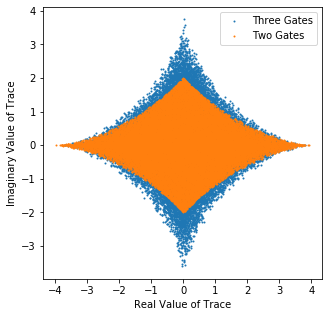

In [186]:
plt.figure(figsize = (5, 5))
plt.xlabel('Real Value of Trace')
plt.ylabel('Imaginary Value of Trace')
plt.scatter(np.real(trace_list2), np.imag(trace_list2), s = 1)
plt.scatter(np.real(trace_list1), np.imag(trace_list1), s = 1)
plt.legend(['Three Gates', 'Two Gates'])

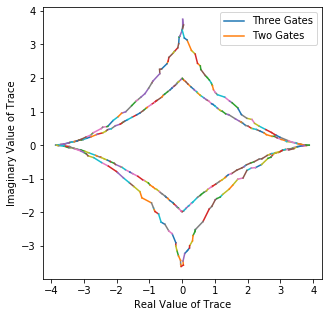

In [194]:
from scipy.spatial import Delaunay
import numpy as np


def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

# Computing the alpha shape
edges1 = alpha_shape(trace_list_1, alpha=0.25, only_outer=True)
edges2 = alpha_shape(trace_list_2, alpha=0.25, only_outer=True)

# Plotting the output
plt.figure(figsize = (5, 5))
plt.xlabel('Real Value of Trace')
plt.ylabel('Imaginary Value of Trace')
for i, j in edges1:
    plt.plot(trace_list_1[[i, j], 0], trace_list_1[[i, j], 1])
    
for i, j in edges2:
    plt.plot(trace_list_2[[i, j], 0], trace_list_2[[i, j], 1])
    
plt.legend(['Three Gates', 'Two Gates'])

In [195]:
boundary = [[trace_list_1[[i, j], 0], trace_list_1[[i, j], 1]] for i, j in edges1]

In [190]:
boundary

[[array([-1.67018098, -1.76390894]), array([0.75736276, 0.70851569])],
 [array([0.26269223, 0.17459598]), array([1.73910161, 1.82030885])],
 [array([3.0688106, 3.1530976]), array([-0.15387139, -0.13263958])],
 [array([-2.42746699, -2.58438138]), array([0.36657917, 0.32667615])],
 [array([-2.78523828, -2.83156617]), array([0.24632869, 0.23368907])],
 [array([-0.49338048, -0.43835771]), array([-1.54755336, -1.58684212])],
 [array([1.22533216, 1.20695776]), array([1.00699121, 1.01410105])],
 [array([-2.0420296 , -2.16771285]), array([0.57579875, 0.48717662])],
 [array([3.35385905, 3.19030068]), array([0.08422021, 0.10667464])],
 [array([-2.16771285, -2.23382527]), array([0.48717662, 0.47237055])],
 [array([3.40083034, 3.41655212]), array([-0.07704408, -0.07157285])],
 [array([-1.88089327, -1.83159926]), array([-0.64235941, -0.66446256])],
 [array([-1.09345797, -1.18309268]), array([1.10693962, 1.03426474])],
 [array([-1.39251671, -1.52941401]), array([0.90143236, 0.83123894])],
 [array([3

Here I plot the density of these points

In [180]:
no_bins = 100

In [187]:
hist, xedges, yedges = np.histogram2d(np.real(trace_list1), np.imag(trace_list1), bins=no_bins)

over_threshold = hist > 0

area1 = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print(f'Area covered by two gates: {area1}')

hist, xedges, yedges = np.histogram2d(np.real(trace_list2), np.imag(trace_list2), bins=no_bins)

over_threshold = hist > 0

area2 = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print(f'Area covered by three gates: {area2}')

Area covered by two gates: 11.649230805418092
Area covered by three gates: 16.806125991069266


In [94]:
10.032153205009198/(4*np.pi)

0.7983333862162072

In [95]:
12.622630378822329 /np.pi

4.017908039222994

If we take the ratio between the area covered by the trace of two $\sqrt{iSWAP}$ gates vs three, we get

In [11]:
print(f"Ratio: {area1/area2 * 100}%")

Ratio: 79.86907163511022%


For Ising $R_{zz}$ gate I find that one gate unitary also has a fixed trace

In [12]:
gate = RZZGate(np.pi/3).to_matrix()

MA = np.kron(random_unitary(2).data, random_unitary(2).data)
MB = np.kron(random_unitary(2).data, random_unitary(2).data)
MC = np.kron(random_unitary(2).data, random_unitary(2).data)
MD = np.kron(random_unitary(2).data, random_unitary(2).data)

M0 = MA
M1 = M0@gate@MB
M2 = M1@gate@MC
M3 = M2@gate@MD

classification(M0, True)
classification(M1, True)
classification(M2, True)
classification(M3, True)

(-4-0j)
(-2-0j)
(0.37623921844325-0j)
(0.02260949323842+1.4839223352391j)


3

We plot this fixed value with the angle theta.

The graph looks alot like the concurrence value for different theta value.

For two gates, we can kinda still see the shape from above

If we change the value of theta, we get different distribution of the orange points. We see that the green points and orange points overlap

In [13]:
def CAN(tx, ty, tz):
    return RZZGate(tx*np.pi).to_matrix()@RYYGate(ty*np.pi).to_matrix()@RXXGate(tz*np.pi).to_matrix()

def get_trace_list(gate, no_points = 1000, five= False):
    
    trace_list2 = [] # Two gates
    trace_list3 = [] # Three gates
    trace_list4 = [] # Four gates
    
    if five:
        trace_list5 = [] # Five gates
    
    for _ in range(no_points):

        MA = np.kron(random_unitary(2).data, random_unitary(2).data)
        MB = np.kron(random_unitary(2).data, random_unitary(2).data)
        MC = np.kron(random_unitary(2).data, random_unitary(2).data)
        MD = np.kron(random_unitary(2).data, random_unitary(2).data)
        ME = np.kron(random_unitary(2).data, random_unitary(2).data)

        M2 = MA@gate@MB@gate@MC
        M3 = M2@gate@MD
        M4 = M3@gate@ME
            
        M2 = to_su(M2)
        M3 = to_su(M3)
        M4 = to_su(M4)

        mat_trace2 = np.trace(gamma_map(M2))
        mat_trace3 = np.trace(gamma_map(M3))
        mat_trace4 = np.trace(gamma_map(M4))

        trace_list2.append(mat_trace2)
        trace_list3.append(mat_trace3)
        trace_list4.append(mat_trace4)
        
        if five:
            MF = np.kron(random_unitary(2).data, random_unitary(2).data)
            M5 = M4@gate@MF
            M5 = to_su(M5)
            mat_trace5 = np.trace(gamma_map(M5))
            trace_list5.append(mat_trace5)

    if five:
        return trace_list2, trace_list3, trace_list4, trace_list5
    else:
        return trace_list2, trace_list3, trace_list4

def plot_trace_map(trace_list2, trace_list3, trace_list4, trace_list5 = None, show = [2, 3, 4]):
    plt.xlabel('Real Value of Trace')
    plt.ylabel('Imaginary Value of Trace')
    
    legend_list = []
    
    if 2 in show:
        plt.scatter(np.real(trace_list2), np.imag(trace_list2), s = 5, c = 'blue')
        legend_list.append('Two Gates')
    if 3 in show:
        plt.scatter(np.real(trace_list3), np.imag(trace_list3), s = 3, c = 'orange')
        legend_list.append('Three Gates')
    if 4 in show:
        plt.scatter(np.real(trace_list4), np.imag(trace_list4), s = 3, c = 'green')
        legend_list.append('Four Gates')
    if 5 in show:
        plt.scatter(np.real(trace_list5), np.imag(trace_list5), s = 3, c = 'grey')
        legend_list.append('Five Gates')
        
    plt.legend(legend_list)
    plt.show()

In [14]:
gate = CAN(1/4, 0, 0)

trace_list2, trace_list3, trace_list4 = get_trace_list(gate, no_points = 5000, five = False)

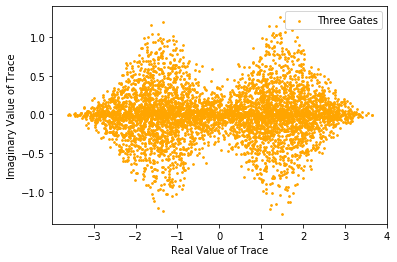

In [17]:
plot_trace_map(trace_list2, trace_list3, trace_list4, show = [3])

In [216]:
vertices = [(0, 0, 0), (1/4, 1/4, -1/4), (1/2, 0, 0), (1/4, 1/4, 1/4), (3/8, 3/8, -1/8), (3/8, -1/8, -1/8)]
vertices = [(1/2, 0, 0), (3/8, 3/8, -1/8), (1/3, 1/3, 0), (1/3, 0, -1/6), (0, 0, 0, 0), (1/4, 1/4, -1/4)]
vertices = [(1/2, 0, 0, -1/2), (3/8, -1/8, -1/8), (1/4, 1/4, -1/4), (1/6, 1/6, 1/6), (0, 0, 0), (1/3, 1/3, -1/6)]

In [217]:
n = 0
for i, vertex1 in enumerate(vertices):
    for j, vertex2 in enumerate(vertices):
        if i<j:
            line = f"({vertex1[0]}+{vertex2[0]-vertex1[0]}t, {vertex1[1]}+{vertex2[1]-vertex1[1]}t, {vertex1[2]}+{vertex2[2]-vertex1[2]}t)"
            #print(f"e{i+1}<-->e{j+1}")
            print(line)
            n+=1

(0.5+-0.125t, 0+-0.125t, 0+-0.125t)
(0.5+-0.25t, 0+0.25t, 0+-0.25t)
(0.5+-0.33333333333333337t, 0+0.16666666666666666t, 0+0.16666666666666666t)
(0.5+-0.5t, 0+0t, 0+0t)
(0.5+-0.16666666666666669t, 0+0.3333333333333333t, 0+-0.16666666666666666t)
(0.375+-0.125t, -0.125+0.375t, -0.125+-0.125t)
(0.375+-0.20833333333333334t, -0.125+0.29166666666666663t, -0.125+0.29166666666666663t)
(0.375+-0.375t, -0.125+0.125t, -0.125+0.125t)
(0.375+-0.041666666666666685t, -0.125+0.4583333333333333t, -0.125+-0.04166666666666666t)
(0.25+-0.08333333333333334t, 0.25+-0.08333333333333334t, -0.25+0.41666666666666663t)
(0.25+-0.25t, 0.25+-0.25t, -0.25+0.25t)
(0.25+0.08333333333333331t, 0.25+0.08333333333333331t, -0.25+0.08333333333333334t)
(0.16666666666666666+-0.16666666666666666t, 0.16666666666666666+-0.16666666666666666t, 0.16666666666666666+-0.16666666666666666t)
(0.16666666666666666+0.16666666666666666t, 0.16666666666666666+0.16666666666666666t, 0.16666666666666666+-0.3333333333333333t)
(0+0.3333333333333333